# Lecture 5 DATA Finance — Exercises (Peru + USA) 

## Learning goals
1. Download market data from **Yahoo Finance** (prices).
2. Compute **daily returns** and **monthly compounded returns**.
3. Download official Peruvian series from **BCRPData**.
4. Reshape data **long → wide**, align to month-end, and merge datasets.
5. Export a clean dataset
## Data used
### Yahoo Finance tickers (USD)
- `EPU`, `IWM`, `IEF`, `VNQ`, `HYG`
### BCRP series codes (monthly, Peru)
- `PD04722MM` : policy reference rate (% annual)
- `PD31895MM` : Peru 10Y government bond yield (PEN)
- `PN01129XM` : EMBIG Peru (country risk spread)
- `PN01246PM` : nominal exchange rate average (PEN per USD)


## 0) Setup

In [380]:
import hashlib
import sys
import io
import numpy as np
import pandas as pd
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import yfinance as fy
from IPython.display import display
from scipy.optimize import minimize

pd.set_option("display.max_columns", 80)


## 1) Parameters

In [381]:

TICKERS = ["EPU", "IWM", "IEF", "VNQ", "HYG"]
PERU_CODES = ["PD04722MM", "PD31895MM", "PN01129XM", "PN01246PM"]

START_YF = "2012-01-01"
START_BCRP = "2005-01-01"

## 2) API helper

In [ ]:

# Yahoo Finance via yfinance 
def yf_adjclose(tickers, start="2012-01-01", end=None):
    # Download DAILY prices from Yahoo Finance.
    # Returns a DataFrame indexed by date with columns=tickers.
    # Prefers 'Adj Close' if available, otherwise uses 'Close'.
    if end is None:
        end = pd.Timestamp.today().strftime("%Y-%m-%d")

    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    # MultiIndex columns when multiple tickers
    if isinstance(df.columns, pd.MultiIndex):
        if "Adj Close" in df.columns.get_level_values(0):
            px = df["Adj Close"].copy()
        else:
            px = df["Close"].copy()
    else:
        # single ticker case
        if "Adj Close" in df.columns:
            px = df[["Adj Close"]].copy()
        else:
            px = df[["Close"]].copy()

        # name the column properly
        if isinstance(tickers, str):
            px.columns = [tickers]
        else:
            # if user passed list of length 1, name it
            px.columns = [list(tickers)[0]]

    px.index = pd.to_datetime(px.index)
    px.index.name = "date"
    return px.dropna(how="all")


# BCRPData API (CSV)
CACHE_DIR = Path(".cache_lecture5")
CACHE_DIR.mkdir(exist_ok=True)

def _hash_key(s):
    import hashlib
    return hashlib.md5(s.encode("utf-8")).hexdigest()

def _clean_bcrp_payload_to_csv_text(txt: str) -> str:
    import re
    # BCRP sometimes wraps CSV in HTML; clean to plain CSV-ish text:
    txt = txt.replace("<br>", "\n").replace("<br/>", "\n").replace("<br />", "\n")
    txt = re.sub(r"<[^>]+>", "", txt)
    lines = [ln.strip() for ln in txt.splitlines() if ln.strip()]
    return "\n".join(lines)

_MONTH_MAP = {
    # Spanish
    "ene": 1, "feb": 2, "mar": 3, "abr": 4, "may": 5, "jun": 6,
    "jul": 7, "ago": 8, "set": 9, "sep": 9, "oct": 10, "nov": 11, "dic": 12,
    # English
    "jan": 1, "apr": 4, "aug": 8, "dec": 12,
}

def _parse_bcrp_period_to_date(s):
    import re
    s0 = str(s).strip().strip('"')
    if not s0:
        return pd.NaT

    # numeric hyphen formats: "2018-5" or "2018-5-5"
    m = re.match(r"^(\d{4})-(\d{1,2})(?:-(\d{1,2}))?$", s0)
    if m:
        y = int(m.group(1)); mo = int(m.group(2)); d = m.group(3)
        if d is None:
            return pd.Timestamp(y, mo, 1)
        return pd.Timestamp(y, mo, int(d))

    # "Ene.2013" / "Jan.2013"
    m = re.match(r"^([A-Za-zÁÉÍÓÚÜÑáéíóúüñ]{3})\.?(\d{4})$", s0)
    if m:
        mon = m.group(1).lower()
        y = int(m.group(2))
        mo = _MONTH_MAP.get(mon)
        return pd.Timestamp(y, mo, 1) if mo else pd.NaT

    # fallback
    dt = pd.to_datetime(s0, errors="coerce", dayfirst=True)
    return dt if not pd.isna(dt) else pd.NaT

def _infer_bcrp_freq(codes_list):
    # crude inference: many monthly series end with "M" or "MM"
    if all(str(c).upper().endswith(("M", "MM")) for c in codes_list):
        return "M"
    if all(str(c).upper().endswith("D") for c in codes_list):
        return "D"
    if all(str(c).upper().endswith("A") for c in codes_list):
        return "A"
    if all(str(c).upper().endswith("Q") for c in codes_list):
        return "Q"
    return "M"

def _to_bcrp_period(x, freq="M"):
    # Converts ISO date strings like '2005-01-01' into BCRP period strings:
    # Monthly -> 'YYYY-M', Daily -> 'YYYY-M-D', Annual -> 'YYYY', Quarterly -> 'YYYY-Q'
    import re
    if x is None:
        return None
    x = str(x)

    # already period-like
    if re.match(r"^\d{4}(-\d{1,2}(-\d{1,2})?)?$", x):
        return x

    dt = pd.to_datetime(x, errors="coerce")
    if pd.isna(dt):
        return x

    if freq == "D":
        return f"{dt.year}-{dt.month}-{dt.day}"
    if freq == "M":
        return f"{dt.year}-{dt.month}"
    if freq == "A":
        return f"{dt.year}"
    if freq == "Q":
        q = (dt.month - 1) // 3 + 1
        return f"{dt.year}-{q}"
    return x

def bcrp_fetch_csv(codes, start="2005-01-01", end=None, lang="esp", timeout=30, use_cache=True):
    """
    Fetch BCRP series using:
    https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}

    Returns LONG DataFrame with columns: date, series_code, value
    """
    import io

    if end is None:
        end = pd.Timestamp.today().strftime("%Y-%m-%d")

    codes_list = list(codes) if isinstance(codes, (list, tuple)) else [str(codes)]
    codes_str = "-".join(codes_list)

    # language mapping (BCRP expects 'esp' or 'ing')
    lang0 = str(lang).lower()
    if lang0 == "es":
        lang0 = "esp"
    if lang0 == "en":
        lang0 = "ing"

    # infer frequency and convert start/end to BCRP period strings
    freq = _infer_bcrp_freq(codes_list)
    start_p = _to_bcrp_period(start, freq=freq)
    end_p   = _to_bcrp_period(end,   freq=freq)

    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes_str}/csv/{start_p}/{end_p}/{lang0}"

    cache_path = CACHE_DIR / f"bcrp_{_hash_key(url)}.csv"
    if use_cache and cache_path.exists():
        return pd.read_csv(cache_path, parse_dates=["date"])

    headers = {"User-Agent": "Mozilla/5.0 (educational notebook)"}
    r = requests.get(url, headers=headers, timeout=timeout)
    r.raise_for_status()

    csv_text = _clean_bcrp_payload_to_csv_text(r.text)
    if not csv_text.strip():
        return pd.DataFrame(columns=["date", "series_code", "value"])

    # Robust CSV parsing (auto-detect separator; skip bad lines)
    dfw = pd.read_csv(
        io.StringIO(csv_text),
        sep=None,
        engine="python",
        on_bad_lines="skip"
    )

    # Need at least 2 columns: period + values
    if dfw.shape[1] < 2:
        return pd.DataFrame(columns=["date", "series_code", "value"])

    # First column is the period
    period_col = dfw.columns[0]
    dfw = dfw.rename(columns={period_col: "date"}).copy()
    dfw["date"] = dfw["date"].apply(_parse_bcrp_period_to_date)
    dfw = dfw.dropna(subset=["date"]).sort_values("date")

    # Convert remaining columns to numeric (handle decimal commas)
    for c in dfw.columns:
        if c == "date":
            continue
        dfw[c] = pd.to_numeric(
            dfw[c].astype(str).str.replace(",", ".", regex=False),
            errors="coerce"
        )

    # If BCRP headers are not the codes, rename by order (best effort)
    series_cols = [c for c in dfw.columns if c != "date"]
    if len(series_cols) == len(codes_list):
        dfw = dfw.rename(columns={series_cols[i]: codes_list[i] for i in range(len(codes_list))})

    # Long format
    out = dfw.melt(id_vars=["date"], var_name="series_code", value_name="value")
    out = out.dropna(subset=["value"]).reset_index(drop=True)

    if use_cache:
        out.to_csv(cache_path, index=False)

    return out

## 3) Exercise 1 — Download daily prices (Yahoo)
1. Use `yf_adjclose(TICKERS, start=START_YF)` to download prices.
2. Print `.shape` and `.columns`.
3. Display `px_daily.head()`.

**Expected**
- index name is `date`
- 5 columns (tickers)


In [383]:
px_daily = yf_adjclose(TICKERS, start=START_YF)

print(px_daily.shape)
print(px_daily.columns)
px_daily.head()

(3513, 5)
Index(['EPU', 'HYG', 'IEF', 'IWM', 'VNQ'], dtype='object', name='Ticker')


Ticker,EPU,HYG,IEF,IWM,VNQ
date,,,,,
2012-01-03,26.398895,41.943405,78.149254,61.923794,33.931320
2012-01-04,26.425713,41.873295,77.903419,61.585140,33.351204
2012-01-05,26.465931,41.690979,77.918335,61.932049,33.664463
2012-01-06,26.325151,41.560078,78.223724,61.775112,33.554241
2012-01-09,26.506172,41.616177,78.238632,62.088970,33.438225


## 4) Exercise 2 — Daily returns and monthly compounded returns

**Tasks**
1. Compute daily returns: `ret_daily = px_daily.pct_change()`
2. Drop all-NaN rows (if any).
3. Compute monthly compounded returns:
   - `(1 + ret_daily).resample("M").prod() - 1`
4. Drop all-NaN rows (if any).

**Hint**
- Returns are decimals: `0.02` = 2%.


In [384]:
# Daily returns 
ret_daily = px_daily.pct_change(fill_method=None)
ret_daily = ret_daily.dropna(how="all")

# Monthly compounded returns at month-end
ret_monthly = (1 + ret_daily).resample("ME").prod() - 1
ret_monthly = ret_monthly.dropna(how="all")
# Inspect the first rows of daily returns
ret_daily.head()

# Inspect the first rows of monthly compounded returns
ret_monthly.head()

Ticker,EPU,HYG,IEF,IWM,VNQ
date,,,,,
2012-01-31,0.098019,0.011369,0.015062,0.054021,0.054881
2012-02-29,0.014108,0.021023,-0.010998,0.025690,-0.011508
2012-03-31,0.064994,-0.009532,-0.015912,0.024847,0.052002
2012-04-30,-0.015845,0.011367,0.025091,-0.016182,0.028594
2012-05-31,-0.077361,-0.032208,0.028696,-0.065791,-0.045059


## 5) Exercise 3 — Download BCRP series and reshape to wide monthly

**Tasks**
1. Download long-format data: `peru_long = bcrp_fetch_csv(PERU_CODES, start=START_BCRP)`
2. Pivot to wide:
   - index=`date`, columns=`series_code`, values=`value`
3. Resample monthly (month-end): `resample("M").last()`

**Expected**
- `peru_wide` columns include all `PERU_CODES`.


In [385]:
# Download BCRP series in long format (date, series_code, value)
peru_long = bcrp_fetch_csv(PERU_CODES, start=START_BCRP)

# Reshape from long to wide:
peru_wide = (
    peru_long
    .pivot(index="date", columns="series_code", values="value")
    .sort_index()  # ensure dates are in increasing order
)

# Convert to a monthly time series indexed at month-end ("ME" = month end):
# For each month, keep the last available observation within that month.
peru_wide = peru_wide.resample("ME").last()

# Inspect the raw outputs:
display(peru_long.head())
display(peru_wide.tail())

# Build a balanced panel (optional):
# Find, for each series (column), the last month-end date where it has a non-missing value.
last_valid = peru_wide.apply(lambda s: s.last_valid_index())

# The "last common" month is the earliest of those last-valid dates:
# after this date, at least one series has missing data.
common_end = last_valid.min()

# Keep observations only up to the last common month-end date.
# This removes trailing months where some series have not been published yet.
peru_wide_balanced = peru_wide.loc[:common_end].copy()

print("Last available date by series:\n", last_valid)
print("Last common month-end date:", common_end)

# Inspect the last rows of the balanced panel.
display(peru_wide_balanced.tail())


,date,series_code,value
0,2005-01-01,PD04722MM,3.0
1,2005-02-01,PD04722MM,3.0
2,2005-03-01,PD04722MM,3.0
3,2005-04-01,PD04722MM,3.0
4,2005-05-01,PD04722MM,3.0


series_code,PD04722MM,PD31895MM,PN01129XM,PN01246PM
date,,,,
2025-08-31,4.50,6.016960,133.322581,3.543200
2025-09-30,4.25,6.125909,124.107143,3.502818
2025-10-31,4.25,6.105836,123.516129,3.414091
2025-11-30,4.25,6.004450,125.600000,3.372850
2025-12-31,4.25,NaN,NaN,NaN


Last available date by series:
 series_code
PD04722MM   2025-12-31
PD31895MM   2025-11-30
PN01129XM   2025-11-30
PN01246PM   2025-11-30
dtype: datetime64[ns]
Last common month-end date: 2025-11-30 00:00:00


series_code,PD04722MM,PD31895MM,PN01129XM,PN01246PM
date,,,,
2025-07-31,4.50,6.187450,140.612903,3.556200
2025-08-31,4.50,6.016960,133.322581,3.543200
2025-09-30,4.25,6.125909,124.107143,3.502818
2025-10-31,4.25,6.105836,123.516129,3.414091
2025-11-30,4.25,6.004450,125.600000,3.372850


## 6) Exercise 4 — Merge and export

**Tasks**
1. Merge returns with Peru series (inner join on month-end index):
   - `df_monthly = ret_monthly.join(peru_wide, how="inner")`
2. Drop missing values.
3. Export CSV to `data_monthly_finance_lecture5.csv`.

**Expected**
- no missing values
- at least 60 months


In [386]:
#1. Merge (inner join on month-end index)
# Recommended: use the balanced panel to avoid trailing missing values
df_monthly = ret_monthly.join(peru_wide_balanced, how="inner")
# If you want the exercise exactly as written, use:
# df_monthly = ret_monthly.join(peru_wide, how="inner")

#2. Drop missing values (any remaining NaNs)
df_monthly = df_monthly.dropna()


print("Shape:", df_monthly.shape)
print("Months:", df_monthly.shape[0])
df_monthly.tail()


Shape: (167, 9)
Months: 167


,EPU,HYG,IEF,IWM,VNQ,PD04722MM,PD31895MM,PN01129XM,PN01246PM
date,,,,,,,,,
2025-07-31,0.001235,0.001358,-0.005939,0.016683,0.000898,4.50,6.187450,140.612903,3.556200
2025-08-31,0.105858,0.011053,0.016482,0.071927,0.034777,4.50,6.016960,133.322581,3.543200
2025-09-30,0.143123,0.008860,0.006511,0.031791,0.000576,4.25,6.125909,124.107143,3.502818
2025-10-31,0.020813,-0.000111,0.007113,0.017648,-0.024502,4.25,6.105836,123.516129,3.414091
2025-11-30,0.026919,0.007464,0.009881,0.010234,0.024221,4.25,6.004450,125.600000,3.372850


In [387]:
#3. Export CSV
OUT = Path("ETF returns (Yahoo) + Peru macro series (BCRP).csv")
df_monthly.to_csv(OUT, index=True)
print("exported ->", OUT.resolve())

exported -> C:\Users\Usuario\Downloads\ETF returns (Yahoo) + Peru macro series (BCRP).csv


## 1) Parameters

In [388]:

TICKERS = ["EPU", "IWM", "IEF", "VNQ", "HYG"]
START = "2012-01-01"


## 2) DataHandler class 

In [389]:
class DataHandler:  # A small helper class to fetch prices, compute returns, and plot results.
    def __init__(self, tickers, start="2012-01-01", end=None):  # Runs when you create the object.
        self.tickers = list(tickers)  # Make sure tickers are stored as a list.
        self.start = start  # Start date for the download.
        self.end = end  # End date for the download (None means "up to today").
        self.prices = None  # This will hold the daily price DataFrame once we download it.

    def download_prices(self):  # Downloads daily prices from Yahoo Finance using yfinance.
        df = yf.download(self.tickers, start=self.start, end=self.end, auto_adjust=False, progress=False)  # Pull data from Yahoo.
        if isinstance(df.columns, pd.MultiIndex):  # With multiple tickers, yfinance returns a MultiIndex column layout.
            px = df["Adj Close"] if "Adj Close" in df.columns.get_level_values(0) else df["Close"]  # Prefer Adj Close if available.
        else:  # With a single ticker, the columns come back in a simpler format.
            px = df[["Adj Close"]] if "Adj Close" in df.columns else df[["Close"]]  # Keep prices as a DataFrame.
            if len(self.tickers) == 1:  # If we asked for exactly one ticker...
                px.columns = self.tickers  # ...rename the column to the ticker symbol.
        px.index = pd.to_datetime(px.index)  # Ensure the index is a proper datetime index.
        px.index.name = "date"  # Label the index as "date".
        self.prices = px.dropna(how="all")  # Drop rows where all tickers are missing.
        return self.prices  # Return the cleaned daily prices.

    def returns(self, freq="M"):  # Computes returns at the chosen frequency ("D", "W", "M", etc.).
        if self.prices is None:  # If we haven't downloaded prices yet...
            self.download_prices()  # ...download them first.

        r_d = self.prices.pct_change().dropna(how="all")  # Daily simple returns: P_t/P_{t-1} - 1.

        if freq == "D":  # If the user wants daily returns...
            return r_d  # ...just return them.

        r_f = (1.0 + r_d).resample(freq).prod() - 1.0  # Compound daily returns inside each period (weekly/monthly/etc.).
        return r_f.dropna(how="all")  # Remove periods where everything is missing.

    def summary_stats(self, freq="M"):  # Builds a quick stats table for returns.
        r = self.returns(freq).dropna(how="all")  # Get returns at the requested frequency.

        stats = pd.DataFrame({  # Create a table with one row per ticker.
            "mean": r.mean(),  # Average return.
            "vol":  r.std(),   # Standard deviation (volatility).
            "min":  r.min(),   # Worst observed return.
            "max":  r.max(),   # Best observed return.
        })

        stats = stats.reindex(self.tickers)  # Keep the rows ordered like the original ticker list.
        return stats  # Return the summary table.

    def plot_prices(self):  # Plots the daily price level series.
        if self.prices is None:  # If prices are not available yet...
            self.download_prices()  # ...download them.

        fig, ax = plt.subplots(figsize=(9, 4))  # Create a figure and axis.
        self.prices.plot(ax=ax)  # Plot all tickers as lines.
        ax.set_title("Price levels")  # Title for the plot.
        ax.set_xlabel("date")  # X-axis label.
        ax.set_ylabel("price")  # Y-axis label.
        ax.legend(title="ticker", ncol=2)  # Legend with a title and two columns.
        plt.show()  # Display the figure.

    def plot_returns_hist(self, freq="M", ticker=None, bins=40):  # Plots a histogram of returns for one ticker.
        r = self.returns(freq)  # Compute returns at the requested frequency.

        if ticker is None:  # If no ticker is given...
            ticker = self.tickers[0]  # ...use the first one by default.
        if ticker not in r.columns:  # Basic check to avoid silent mistakes.
            raise ValueError(f"ticker '{ticker}' not found. Available: {list(r.columns)}")  # Raise a clear error.

        x = r[ticker].dropna().values  # Extract the return series and drop missing values.

        fig, ax = plt.subplots(figsize=(7, 4))  # Create the plot canvas.
        ax.hist(x, bins=bins)  # Draw the histogram.
        ax.set_title(f"Histogram of returns ({ticker}) — freq={freq}")  # Title.
        ax.set_xlabel("return")  # X-axis label.
        ax.set_ylabel("count")  # Y-axis label.
        plt.show()  # Display the plot.

    @staticmethod
    def ecdf(x):  # Computes the empirical CDF for an array-like input.
        x = np.asarray(x, dtype=float)  # Convert to a numeric numpy array.
        x = x[~np.isnan(x)]  # Remove NaN values.
        x = np.sort(x)  # Sort from smallest to largest.

        n = x.size  # Number of valid observations.
        if n == 0:  # If there is no data...
            return np.array([]), np.array([])  # ...return empty arrays.

        y = np.arange(1, n + 1) / n  # Cumulative probabilities: 1/n, 2/n, ..., 1.
        return x, y  # Return the (sorted values, cumulative probabilities).

    def plot_cdf(self, freq="M", ticker=None):  # Plots the empirical CDF of returns for one ticker.
        r = self.returns(freq)  # Compute returns at the requested frequency.

        if ticker is None:  # If no ticker is given...
            ticker = self.tickers[0]  # ...use the first one.
        if ticker not in r.columns:  # Check that the ticker exists in the return DataFrame.
            raise ValueError(f"ticker '{ticker}' not found. Available: {list(r.columns)}")  # Raise a clear error.

        xs, ys = self.ecdf(r[ticker].values)  # Compute ECDF points for that ticker.

        fig, ax = plt.subplots(figsize=(7, 4))  # Create the plot.
        ax.plot(xs, ys)  # Plot the ECDF curve.
        ax.set_title(f"Empirical CDF ({ticker}) — freq={freq}")  # Title.
        ax.set_xlabel("return")  # X-axis label.
        ax.set_ylabel("F(r)")  # Y-axis label (the CDF).
        plt.show()  # Display the figure.


## 3) Exercise 1 — Download prices and inspect

**Tasks**
1. Create `dh` and call `dh.download_prices()`.
2. Print `.shape` and display `.head()`.


In [390]:
dh = DataHandler(TICKERS, start=START)
prices = dh.download_prices()  # API ready

# inspect
print("Shape:", prices.shape)
print("Columns:", list(prices.columns))
prices.head()

Shape: (3513, 5)
Columns: ['EPU', 'HYG', 'IEF', 'IWM', 'VNQ']


Ticker,EPU,HYG,IEF,IWM,VNQ
date,,,,,
2012-01-03,26.398905,41.943409,78.149246,61.923801,33.931313
2012-01-04,26.425714,41.873268,77.903397,61.585125,33.351200
2012-01-05,26.465935,41.690990,77.918327,61.932049,33.664471
2012-01-06,26.325165,41.560070,78.223747,61.775105,33.554249
2012-01-09,26.506151,41.616165,78.238640,62.089001,33.438225


## 4) Exercise 2 — Weekly vs monthly returns

**Tasks**
1. Implement `returns()`.
2. Compute weekly and monthly returns and compare sizes.


In [391]:
# This is already implemented in the script above.
# def returns(self, freq="M"):
#     #1. Ensure we have prices
#     if self.prices is None:
#         self.download_prices()
#     #2. Daily returns
#     r_d = self.prices.pct_change().dropna(how="all")
#     #3. Daily requested
#     if freq == "D":
#         return r_d
#     #4. Compound within each period (weekly/monthly/etc.)
#     r_f = (1 + r_d).resample(freq).prod() - 1
#     #5. Drop all-NaN rows
#     return r_f.dropna(how="all")


In [392]:
r_w = dh.returns("W")
r_m = dh.returns("M")

print("weekly:", r_w.shape, "monthly:", r_m.shape)
r_m.tail()


weekly: (729, 5) monthly: (168, 5)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r_d = self.prices.pct_change().dropna(how="all")  # Daily simple returns: P_t/P_{t-1} - 1.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r_d = self.prices.pct_change().dropna(how="all")  # Daily simple returns: P_t/P_{t-1} - 1.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  r_f = (1.0 

Ticker,EPU,HYG,IEF,IWM,VNQ
date,,,,,
2025-08-31,0.105858,0.011053,0.016482,0.071927,0.034777
2025-09-30,0.143123,0.008860,0.006511,0.031791,0.000576
2025-10-31,0.020813,-0.000111,0.007113,0.017648,-0.024502
2025-11-30,0.026919,0.007464,0.009881,0.010234,0.024221
2025-12-31,0.108937,0.001561,-0.006786,0.011582,-0.030107


## 5) Exercise 3 — Monthly summary statistics

**Tasks**
1. Implement `summary_stats()`.
2. Create a table of mean/vol/min/max.


In [393]:
# This is already implemented in the script above.
# def summary_stats(self, freq="M"):
#     # 1) Get returns at the requested frequency
#     r = self.returns(freq).dropna(how="all")
#     # 2) Build stats table
#     stats = pd.DataFrame({
#         "mean": r.mean(),
#         "vol":  r.std(),
#         "min":  r.min(),
#         "max":  r.max(),
#     })
#     # 3) Keep index as tickers in the same order
#     stats.index.name = "ticker"
#     return stats.reindex(self.tickers)


In [394]:
# mean = average monthly return, vol = monthly volatility (std),
# min/max = worst/best monthly return observed
stats_m = dh.summary_stats("M")
stats_m

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r_d = self.prices.pct_change().dropna(how="all")  # Daily simple returns: P_t/P_{t-1} - 1.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  r_f = (1.0 + r_d).resample(freq).prod() - 1.0  # Compound daily returns inside each period (weekly/monthly/etc.).


,mean,vol,min,max
Ticker,,,,
EPU,0.008224,0.067818,-0.261204,0.202099
IWM,0.009856,0.054625,-0.214771,0.182442
IEF,0.001403,0.018082,-0.047350,0.045544
VNQ,0.006897,0.048209,-0.193918,0.120818
HYG,0.004085,0.020344,-0.100281,0.066988


## 6) Exercise 4 — Distribution plots (histogram + ECDF)

**Tasks**
1. Implement the plotting methods + `ecdf`.
2. Plot monthly return histogram and ECDF for `EPU`.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r_d = self.prices.pct_change().dropna(how="all")  # Daily simple returns: P_t/P_{t-1} - 1.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  r_f = (1.0 + r_d).resample(freq).prod() - 1.0  # Compound daily returns inside each period (weekly/monthly/etc.).


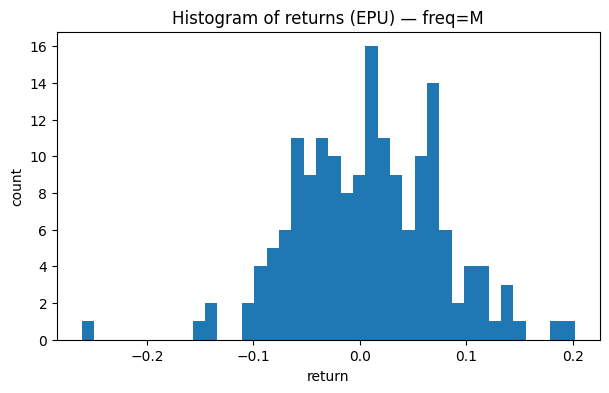

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r_d = self.prices.pct_change().dropna(how="all")  # Daily simple returns: P_t/P_{t-1} - 1.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\3412613444.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  r_f = (1.0 + r_d).resample(freq).prod() - 1.0  # Compound daily returns inside each period (weekly/monthly/etc.).


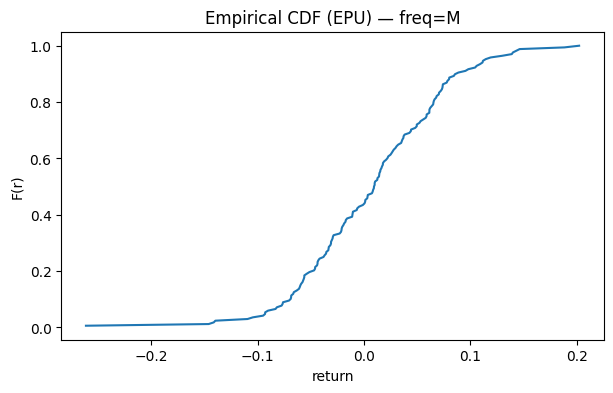

In [395]:
# def plot_returns_hist(self, freq="M", ticker=None, bins=40):
#     # Plot a histogram of returns for one ticker at a given frequency.
#     r = self.returns(freq)
#     # Default ticker = first one
#     if ticker is None:
#         ticker = self.tickers[0]
#     # Select the return series and drop NaNs
#     x = r[ticker].dropna().values
#     fig, ax = plt.subplots(figsize=(7, 4))
#     ax.hist(x, bins=bins)
#     ax.set_title(f"Histogram of returns ({ticker}) — freq={freq}")
#     ax.set_xlabel("return")
#     ax.set_ylabel("count")
#     plt.show()
# @staticmethod
# def ecdf(x):
#     # Empirical CDF: returns sorted values (xs) and cumulative probabilities (ys).
#     x = np.asarray(x, dtype=float)
#     x = x[~np.isnan(x)]
#     x = np.sort(x)
#     n = x.size
#     if n == 0:
#         return np.array([]), np.array([])
#     ys = np.arange(1, n + 1) / n
#     return x, ys
# def plot_cdf(self, freq="M", ticker=None):
#     # Plot the empirical CDF of returns for one ticker.
#     r = self.returns(freq)
#     # Default ticker = first one
#     if ticker is None:
#         ticker = self.tickers[0]
#     xs, ys = self.ecdf(r[ticker].values)
#     fig, ax = plt.subplots(figsize=(7, 4))
#     ax.plot(xs, ys)
#     ax.set_title(f"Empirical CDF ({ticker}) — freq={freq}")
#     ax.set_xlabel("return")
#     ax.set_ylabel("F(r)")
#     plt.show()
dh.plot_returns_hist(freq="M", ticker="EPU")
dh.plot_cdf(freq="M", ticker="EPU")


##Parameters-Yahoo helper

In [396]:

TICKERS = ["EPU", "IWM", "IEF", "VNQ", "HYG"]
START = "2012-01-01"
CSV_PATH = Path("ETF returns (Yahoo) + Peru macro series (BCRP).csv")


In [397]:
def yf_adjclose(tickers, start="2012-01-01", end=None):
    if end is None:                                   # If end date is not provided
        end = pd.Timestamp.today().strftime("%Y-%m-%d")# Use today's date as the end date (string)

    # Download price data from Yahoo Finance for the given tickers and date range
    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    if isinstance(df.columns, pd.MultiIndex):          # If yfinance returned a MultiIndex (multiple tickers)
        # Pick the "Adj Close" panel if available, otherwise use "Close"
        px = df["Adj Close"] if "Adj Close" in df.columns.get_level_values(0) else df["Close"]
    else:                                              # If yfinance returned a flat columns DataFrame (often single ticker)
        # Select the adjusted close column if present, otherwise select close
        px = df[["Adj Close"]] if "Adj Close" in df.columns else df[["Close"]]
        if isinstance(tickers, str):                   # If tickers was given as a single string (not a list)
            px.columns = [tickers]                     # Rename the column to the ticker symbol

    px.index = pd.to_datetime(px.index)                # Ensure the index is datetime
    px.index.name = "date"                             # Name the index "date"
    return px.dropna(how="all")                        # Drop rows where all tickers are missing, then return


## Load monthly returns (scaffold)

In [398]:
if CSV_PATH.exists():                                  # If the CSV file already exists locally
    df = pd.read_csv(CSV_PATH, parse_dates=["date"]).set_index("date")  # Read CSV, parse date, set it as index
    R = df[TICKERS].dropna().copy()                    # Keep only the ETF columns, drop missing rows, copy
else:                                                  # Otherwise (CSV not found)
    px = yf_adjclose(TICKERS, start=START)             # Download adjusted close prices from Yahoo
    ret_daily = px.pct_change().dropna(how="all")      # Compute daily returns and drop empty rows
    R = (1 + ret_daily).resample("M").prod() - 1       # Convert daily returns to monthly (compound within each month)
    R = R.dropna(how="all")                            # Drop months where all assets are missing

R.tail()  

,EPU,IWM,IEF,VNQ,HYG
date,,,,,
2025-07-31,0.001235,0.016683,-0.005939,0.000898,0.001358
2025-08-31,0.105858,0.071927,0.016482,0.034777,0.011053
2025-09-30,0.143123,0.031791,0.006511,0.000576,0.008860
2025-10-31,0.020813,0.017648,0.007113,-0.024502,-0.000111
2025-11-30,0.026919,0.010234,0.009881,0.024221,0.007464


## 4) Exercise 1 — Implement ECDF

Return `(xs, ys)` where:
- `xs` sorted values
- `ys` = 1..n / n


In [399]:
def ecdf(x):
    """
    Empirical CDF.
    Returns (xs, ys) where:
      - xs are the sorted (finite) values
      - ys are ranks / n = 1..n / n
    """
    x = np.asarray(x).ravel()             # Convert input x to a 1D NumPy array

    # keep only finite values (drops NaN, inf, -inf)
    x = x[np.isfinite(x)]                # Remove NaN/inf/-inf values
    if x.size == 0:                      # If nothing remains after cleaning
        return np.array([]), np.array([])# Return empty arrays

    xs = np.sort(x)                      # Sort the values from smallest to largest
    n = xs.size                          # Number of observations
    ys = np.arange(1, n + 1) / n         # ECDF values: 1/n, 2/n, ..., n/n
    return xs, ys                        # Return sorted x-values and ECDF values

## 5) Exercise 2 — Plot ECDFs for all assets

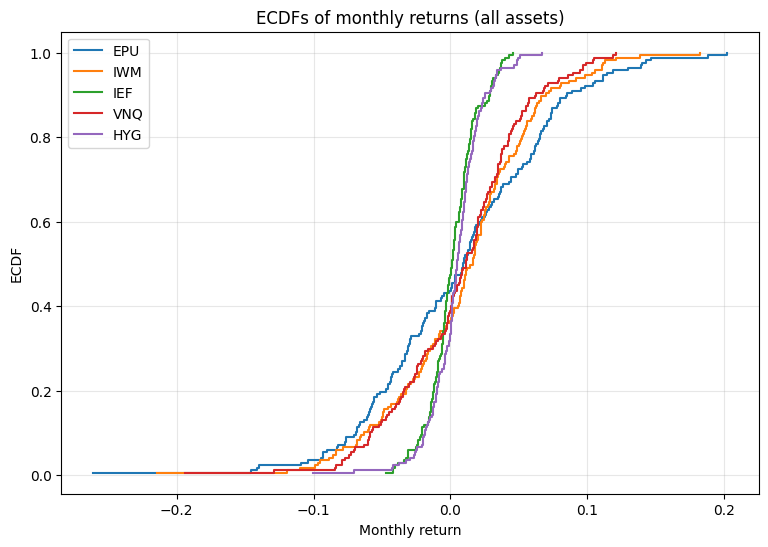

In [400]:
plt.figure(figsize=(9, 6))               # Create a new figure with a chosen size

for tkr in R.columns:                    # Loop over each asset column in R (each ticker)
    x = R[tkr].dropna().values           # Get the returns for that ticker, drop NaNs, convert to array
    xs, ys = ecdf(x)                     # Compute ECDF points (xs sorted, ys cumulative probs)
    if xs.size == 0:                     # If the ticker has no valid data
        continue                         # Skip it
    plt.step(xs, ys, where="post", label=tkr)  # Plot ECDF as a step function, label with ticker

plt.xlabel("Monthly return")             # Label the x-axis
plt.ylabel("ECDF")                       # Label the y-axis
plt.title("ECDFs of monthly returns (all assets)")  # Title of the plot
plt.legend()                             # Show legend with tickers
plt.grid(True, alpha=0.3)                # Add a light grid to help reading
plt.show()                               # Display the figure

## 6) Exercise 3 — FOSD and SOSD (grid approximation)
1. Implement `fosd_dominates` and `sosd_dominates`.
2. Fill a dominance table comparing EPU to each other asset.

Hint:
- grid = np.linspace(min(x,y), max(x,y), K)
- Fx(t) = mean(x <= t)
- SOSD uses cumulative integral of Fx


In [401]:
def fosd_dominates(x, y, grid=None, K=2000, tol=1e-10):
    x = np.asarray(x).ravel()                # Convert x to a 1D NumPy array
    y = np.asarray(y).ravel()                # Convert y to a 1D NumPy array
    x = x[np.isfinite(x)]                    # Remove NaN/inf from x
    y = y[np.isfinite(y)]                    # Remove NaN/inf from y
    if x.size == 0 or y.size == 0:           # If either sample is empty after cleaning
        return False                         # Cannot dominate -> return False

    if grid is None:                         # If user did not provide a grid
        # Create an evenly spaced grid covering both samples' ranges
        grid = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), K)

    # Empirical CDF of x evaluated on the grid: Fx(t) = P(x <= t)
    Fx = np.array([(x <= t).mean() for t in grid])
    # Empirical CDF of y evaluated on the grid: Fy(t) = P(y <= t)
    Fy = np.array([(y <= t).mean() for t in grid])

    # FOSD condition (grid approximation): Fx(t) <= Fy(t) for all t
    # tol allows a tiny numerical slack
    return np.all(Fx <= Fy + tol)


def sosd_dominates(x, y, grid=None, K=2000, tol=1e-10):
    x = np.asarray(x).ravel()                # Convert x to a 1D NumPy array
    y = np.asarray(y).ravel()                # Convert y to a 1D NumPy array
    x = x[np.isfinite(x)]                    # Remove NaN/inf from x
    y = y[np.isfinite(y)]                    # Remove NaN/inf from y
    if x.size == 0 or y.size == 0:           # If either sample is empty after cleaning
        return False                         # Cannot dominate -> return False

    if grid is None:                         # If user did not provide a grid
        # Create an evenly spaced grid covering both samples' ranges
        grid = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), K)

    # Empirical CDFs on the grid
    Fx = np.array([(x <= t).mean() for t in grid])  # Fx(t)
    Fy = np.array([(y <= t).mean() for t in grid])  # Fy(t)

    dx = np.diff(grid)                       # Step sizes between adjacent grid points (Δt)

    int_Fx = np.zeros_like(grid, dtype=float)  # Allocate array for ∫ Fx up to each grid point
    int_Fy = np.zeros_like(grid, dtype=float)  # Allocate array for ∫ Fy up to each grid point

    # Cumulative trapezoid integration:
    # int_Fx[j] ≈ ∫_{grid[0]}^{grid[j]} Fx(s) ds
    int_Fx[1:] = np.cumsum(0.5 * (Fx[1:] + Fx[:-1]) * dx)

    # int_Fy[j] ≈ ∫_{grid[0]}^{grid[j]} Fy(s) ds
    int_Fy[1:] = np.cumsum(0.5 * (Fy[1:] + Fy[:-1]) * dx)

    # SOSD condition (grid approximation): ∫Fx <= ∫Fy for all grid points
    # tol allows a tiny numerical slack
    return np.all(int_Fx <= int_Fy + tol)

In [402]:
rows = []                                    # Create an empty list to store results (one dict per row)
x = R["EPU"].dropna().values                 # Take EPU returns, drop NaNs, convert to NumPy array

for b in ["IWM", "IEF", "VNQ", "HYG"]:        # Loop over the other assets
    y = R[b].dropna().values                 # Take asset b returns, drop NaNs, convert to NumPy array

    # Create a grid that covers both x and y ranges (so CDFs are comparable)
    grid = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), 2000)

    rows.append({                            # Append one row of results as a dictionary
        "compare": f"EPU vs {b}",             # Label for the comparison
        "EPU_FOSD_b": fosd_dominates(x, y, grid=grid),   # Does EPU FOSD-dominate b?
        "EPU_SOSD_b": sosd_dominates(x, y, grid=grid),   # Does EPU SOSD-dominate b?
        "b_FOSD_EPU": fosd_dominates(y, x, grid=grid),   # Does b FOSD-dominate EPU?
        "b_SOSD_EPU": sosd_dominates(y, x, grid=grid),   # Does b SOSD-dominate EPU?
    })

dominance_table = pd.DataFrame(rows)          # Convert list of dicts into a DataFrame
dominance_table 

,compare,EPU_FOSD_b,EPU_SOSD_b,b_FOSD_EPU,b_SOSD_EPU
0,EPU vs IWM,False,False,False,True
1,EPU vs IEF,False,False,False,False
2,EPU vs VNQ,False,False,False,False
3,EPU vs HYG,False,False,False,False


## 7) Exercise 4 — Bootstrap a simple SOSD gap

Tasks:
1. Implement `sosd_gap`
2. Implement `bootstrap_gap` returning (gap_hat, p_value)
3. Fill a results table for EPU vs each asset.


In [403]:
def sosd_gap(x, y, grid=None, K=2000):
    """
    Simple SOSD 'gap' on a grid:
      gap(x,y) = max_t [ ∫ (F_x(s) - F_y(s)) ds ]  (approximated on a grid)
    """

    x = np.asarray(x).ravel()   # Convert x to a 1D NumPy array
    y = np.asarray(y).ravel()   # Convert y to a 1D NumPy array

    x = x[np.isfinite(x)]       # Keep only finite values (drop NaN, inf, -inf)
    y = y[np.isfinite(y)]       # Keep only finite values (drop NaN, inf, -inf)

    if x.size == 0 or y.size == 0:  # If either sample is empty after cleaning
        return np.nan               # Return NaN (cannot compute)

    if grid is None:  # If no grid provided by the user
        # Build an evenly spaced grid covering the support of both samples
        grid = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), K)
    else:
        grid = np.asarray(grid)  # Ensure grid is a NumPy array

    # Compute empirical CDF values on the grid:
    # Fx(t) = fraction of x values <= t, for each t in grid
    Fx = np.array([(x <= t).mean() for t in grid])
    # Fy(t) = fraction of y values <= t, for each t in grid
    Fy = np.array([(y <= t).mean() for t in grid])

    dx = np.diff(grid)          # Differences between consecutive grid points (Δt)

    int_diff = np.zeros_like(grid, dtype=float)  # Allocate integral array (same length as grid)

    # Trapezoidal cumulative integral of (Fx - Fy):
    # int_diff[j] ≈ ∫_{grid[0]}^{grid[j]} (Fx(s) - Fy(s)) ds
    int_diff[1:] = np.cumsum(
        0.5 * ((Fx[1:] - Fy[1:]) + (Fx[:-1] - Fy[:-1])) * dx
    )

    return float(np.max(int_diff))  # The SOSD gap = maximum value of the cumulative integral


def bootstrap_gap(x, y, B=1000, seed=7):
    """
    Bootstrap test (one-sided) for SOSD:
      H0: x SOSD y  (gap <= 0)
      H1: x does NOT SOSD y (gap > 0)

    Returns (gap_hat, p_value) where p_value = P*(gap_boot >= gap_hat).
    """

    x = np.asarray(x).ravel()     # Convert x to 1D array
    y = np.asarray(y).ravel()     # Convert y to 1D array

    x = x[np.isfinite(x)]         # Drop NaN/inf from x
    y = y[np.isfinite(y)]         # Drop NaN/inf from y

    if x.size == 0 or y.size == 0:  # If either sample is empty
        return np.nan, np.nan        # Return NaNs

    # Fix ONE grid based on the original samples (keep grid constant across bootstrap reps)
    grid = np.linspace(min(x.min(), y.min()), max(x.max(), y.max()), 2000)

    gap_hat = sosd_gap(x, y, grid=grid)  # Compute the observed (original sample) SOSD gap

    rng = np.random.default_rng(seed)    # Random number generator with a fixed seed (reproducible)
    n, m = x.size, y.size                # Sample sizes for x and y

    gaps = np.empty(B, dtype=float)      # Allocate array to store bootstrap gaps

    for b in range(B):                   # Repeat bootstrap B times
        # Resample x with replacement (same size n)
        xb = x[rng.integers(0, n, size=n)]
        # Resample y with replacement (same size m)
        yb = y[rng.integers(0, m, size=m)]

        # Compute SOSD gap for the bootstrap samples using the SAME grid
        gaps[b] = sosd_gap(xb, yb, grid=grid)

    # One-sided bootstrap p-value:
    # fraction of bootstrap gaps that are >= the observed gap
    p_value = float(np.mean(gaps >= gap_hat))

    return float(gap_hat), p_value        # Return observed gap and its bootstrap p-value

In [404]:
rows = []
x = R["EPU"].dropna().values

for b in ["IWM", "IEF", "VNQ", "HYG"]:
    y = R[b].dropna().values
    g, p = bootstrap_gap(x, y, B=1000, seed=7)
    rows.append({"compare": f"EPU vs {b}", "gap_SOSD": g, "p_value": p})

gap_table = pd.DataFrame(rows)
gap_table

,compare,gap_SOSD,p_value
0,EPU vs IWM,0.007538,0.498
1,EPU vs IEF,0.016746,0.480
2,EPU vs VNQ,0.007952,0.501
3,EPU vs HYG,0.017719,0.466


In [405]:

ASSETS = ["EPU", "IWM", "IEF", "VNQ", "HYG"]
START = "2012-01-01"
CSV_PATH = Path("data_monthly_finance_lecture5.csv")

RF_CODE = "PD04722MM"
BCRP_START = "2005-01-01"

W_MIN = 0.0
W_MAX = 0.60


## 3) Load data (scaffold)

In [406]:

if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH, parse_dates=["date"]).set_index("date")
    R = df[ASSETS].dropna().copy()
else:
    px = yf_adjclose(ASSETS, start=START)
    ret_daily = px.pct_change().dropna(how="all")
    R = (1 + ret_daily).resample("M").prod() - 1
    R = R.dropna(how="all")

rf_long = bcrp_fetch_csv([RF_CODE], start=BCRP_START, lang="es")
rf_wide = rf_long.pivot_table(index="date", columns="series_code", values="value", aggfunc="last").resample("M").last()
rf = (rf_wide.reindex(R.index)[RF_CODE] / 100.0) / 12.0
rf = rf.fillna(0.0)

R.tail(), rf.tail()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14124\1652827576.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rf_wide = rf_long.pivot_table(index="date", columns="series_code", values="value", aggfunc="last").resample("M").last()


(                 EPU       IWM       IEF       VNQ       HYG
 date                                                        
 2025-07-31  0.001235  0.016683 -0.005939  0.000898  0.001358
 2025-08-31  0.105858  0.071927  0.016482  0.034777  0.011053
 2025-09-30  0.143123  0.031791  0.006511  0.000576  0.008860
 2025-10-31  0.020813  0.017648  0.007113 -0.024502 -0.000111
 2025-11-30  0.026919  0.010234  0.009881  0.024221  0.007464,
 date
 2025-07-31    0.003750
 2025-08-31    0.003750
 2025-09-30    0.003542
 2025-10-31    0.003542
 2025-11-30    0.003542
 Name: PD04722MM, dtype: float64)

## 4) Exercise 1 — Portfolio return / variance

In [407]:
def portfolio_return(w, mu):
    # Ensure inputs are NumPy arrays (1D)
    w = np.asarray(w).ravel()
    mu = np.asarray(mu).ravel()
    # Portfolio expected return: w' * mu
    return float(w @ mu)

def portfolio_var(w, Sigma):
    # Ensure inputs are NumPy arrays
    w = np.asarray(w).ravel()
    Sigma = np.asarray(Sigma)
    # Portfolio variance: w' * Sigma * w
    return float(w @ Sigma @ w)


## 5) Exercise 2 — Minimum variance (SLSQP)

In [408]:

def min_variance(Sigma, bounds, w0=None):
    """
    Minimum-variance portfolio with sum of weights = 1.
    Uses SLSQP with box constraints (bounds).

    Parameters
    ----------
    Sigma : (n,n) array
        Covariance matrix.
    bounds : list of (low, high)
        Bounds for each weight (length n).
    w0 : (n,) array or None
        Initial guess. If None, use equal weights.

    Returns
    -------
    w_hat : (n,) np.ndarray
        Optimal weights.
    res : OptimizeResult
        Full scipy result object.
    """
    Sigma = np.asarray(Sigma)
    n = Sigma.shape[0]

    if w0 is None:
        w0 = np.ones(n) / n
    else:
        w0 = np.asarray(w0).ravel()

    # objective: portfolio variance
    def obj(w):
        return float(w @ Sigma @ w)

    # equality constraint: sum(w) = 1
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}

    res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=[cons])

    if not res.success:
        raise RuntimeError(f"SLSQP failed: {res.message}")

    return res.x, res

## 6) Exercise 3 — Maximum Sharpe (SLSQP)

In [409]:
def max_sharpe(mu, Sigma, rf, bounds, w0=None):
    mu = np.asarray(mu).ravel()
    Sigma = np.asarray(Sigma)
    n = mu.size

    if w0 is None:
        w0 = np.ones(n) / n
    else:
        w0 = np.asarray(w0).ravel()

    def neg_sharpe(w):
        port_ret = float(w @ mu)
        port_var = float(w @ Sigma @ w)
        port_vol = np.sqrt(max(port_var, 0.0))     # guard against tiny negatives from numerics
        if port_vol <= 1e-12:
            return 1e9                             # penalize near-zero volatility
        return - (port_ret - float(rf)) / port_vol

    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}

    res = minimize(neg_sharpe, w0, method="SLSQP", bounds=bounds, constraints=[cons])

    if not res.success:
        raise RuntimeError(f"SLSQP failed: {res.message}")

    return res.x, res


## 7) Exercise 4 — Efficient frontier

In [410]:
def efficient_frontier(mu, Sigma, R_targets, bounds):
    mu = np.asarray(mu).ravel()
    Sigma = np.asarray(Sigma)
    R_targets = np.asarray(R_targets).ravel()

    n = mu.size
    w0 = np.ones(n) / n  # initial guess

    def obj(w):
        return float(w @ Sigma @ w)

    rows = []
    for Rt in R_targets:
        cons = [
            {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},     # budget
            {"type": "eq", "fun": lambda w, Rt=Rt: (w @ mu) - Rt} # target return
        ]

        res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)

        if res.success:
            w_hat = res.x
            var = float(w_hat @ Sigma @ w_hat)
            vol = float(np.sqrt(max(var, 0.0)))
        else:
            w_hat = np.full(n, np.nan)
            var = np.nan
            vol = np.nan

        row = {
            "R_target": float(Rt),
            "var": var,
            "vol": vol,
            "success": bool(res.success),
        }
        for j in range(n):
            row[f"w_{j}"] = w_hat[j]
        rows.append(row)

    return pd.DataFrame(rows)

## 8) Exercise 5 — Run + plot frontier

w_minv: [0.     0.     0.5461 0.0659 0.3879]
w_msr:  [0.1357 0.6    0.     0.2643 0.    ]


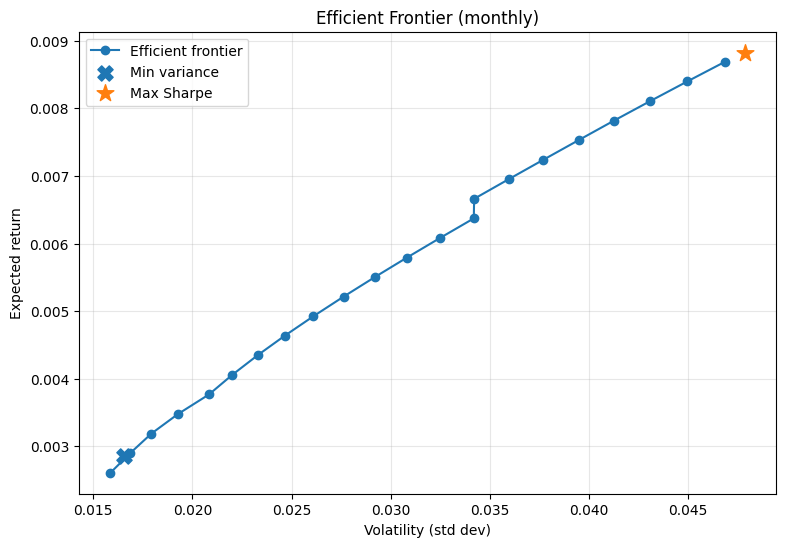

,R_target,var,vol,success,w_0,w_1,w_2,w_3,w_4
0,0.001452,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
1,0.001741,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
2,0.002030,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
3,0.002320,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
4,0.002609,0.000252,0.01587,True,0.0,0.0,0.6,0.032559,0.367441


In [411]:
# ## 8) Exercise 5 — Run + plot frontier

mu = R.mean().values
Sigma = R.cov().values
bounds = [(W_MIN, W_MAX)] * len(ASSETS)

# --- compute min-variance and max-sharpe weights ---
w_minv, res_minv = min_variance(Sigma, bounds=bounds)
w_msr,  res_msr  = max_sharpe(mu, Sigma, rf=float(rf.mean()), bounds=bounds)

print("w_minv:", np.round(w_minv, 4))
print("w_msr: ", np.round(w_msr, 4))

# --- frontier ---
R_targets = np.linspace(mu.min(), mu.max(), 30)
front = efficient_frontier(mu, Sigma, R_targets, bounds=bounds)

# --- plot ---
plt.figure(figsize=(9, 6))
plt.plot(front["vol"], front["R_target"], marker="o", linestyle="-", label="Efficient frontier")

# plot min-var and max-sharpe points
vol_minv = np.sqrt(portfolio_var(w_minv, Sigma))
ret_minv = portfolio_return(w_minv, mu)
plt.scatter([vol_minv], [ret_minv], marker="X", s=120, label="Min variance")

vol_msr = np.sqrt(portfolio_var(w_msr, Sigma))
ret_msr = portfolio_return(w_msr, mu)
plt.scatter([vol_msr], [ret_msr], marker="*", s=160, label="Max Sharpe")

plt.xlabel("Volatility (std dev)")
plt.ylabel("Expected return")
plt.title("Efficient Frontier (monthly)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

front.head()


## 9) Exercise 6 — Expanding-window backtest

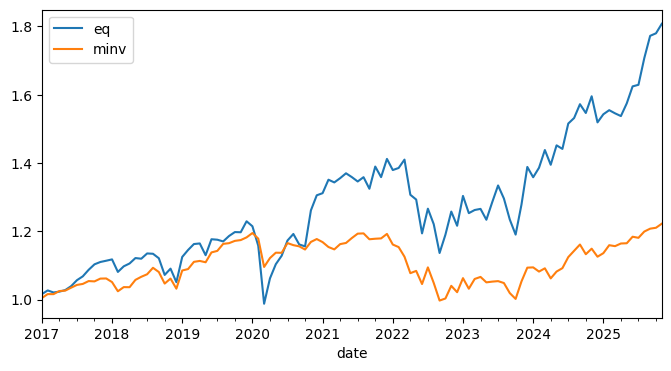

In [412]:
def backtest_expanding(R, rf, start_window=60):
    """
    Expanding-window backtest.

    At each month t (starting at start_window):
      - Estimate mu and Sigma using data up to t-1
      - Compute min-variance weights (with bounds W_MIN..W_MAX)
      - Compute next-month realized returns for:
          eq   = equal-weight portfolio
          minv = min-variance portfolio
      - Also compute excess returns vs rf

    Returns a DataFrame indexed by date with columns:
      eq, minv, rf, eq_excess, minv_excess
    """
    R = R.copy()
    rf = rf.copy()

    # align indices and drop months with missing data across assets (simple for class exercises)
    df = R.join(rf.rename("rf"), how="inner").dropna()
    assets = list(R.columns)
    n = len(assets)

    bounds = [(W_MIN, W_MAX)] * n
    w_eq = np.ones(n) / n

    rows = []
    dates = df.index

    for t in range(start_window, len(dates)):
        # expanding in-sample window up to t-1
        insample = df.iloc[:t]
        mu = insample[assets].mean().values
        Sigma = insample[assets].cov().values

        # compute min-variance weights from in-sample estimates
        w_minv, _ = min_variance(Sigma, bounds=bounds)

        # next-month realized asset returns
        r_next = df.iloc[t][assets].values
        rf_next = float(df.iloc[t]["rf"])

        # portfolio realized returns
        r_eq = float(w_eq @ r_next)
        r_minv = float(w_minv @ r_next)

        rows.append({
            "date": dates[t],
            "eq": r_eq,
            "minv": r_minv,
            "rf": rf_next,
            "eq_excess": r_eq - rf_next,
            "minv_excess": r_minv - rf_next,
        })

    bt = pd.DataFrame(rows).set_index("date")
    bt.index.name = "date"
    return bt
# Run + plot
bt = backtest_expanding(R, rf, start_window=60)
cum = (1 + bt[["eq", "minv"]]).cumprod()
cum.plot(figsize=(8,4))
plt.show()
